In [1]:
# Don't use this or you can't visualise the data for some reason
#import findspark
#import streamlit
#findspark.init()

In [2]:
#Imports
import pyspark
from pyspark import SparkContext, SparkConf
from collections import Counter
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split, col

from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master('local[10]').config('spark.driver.memory','10g').getOrCreate()

conf = SparkConf().setAppName('Project').setMaster('local')
sparkContext = SparkContext.getOrCreate(conf=conf) #SparkContext(conf = conf)

/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/18 12:44:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Read in and assign column names
# Income data
Income = spark.read.csv('income_csv_cleaned_no_commas.csv',header=False)
Income = Income.toDF('Area_code','Area','Self_num_ind','Self_mean','Self_median','Num_ind','Mean','Median','Pens_num_ind','Pens_mean',
                     'Pens_median','Other_num_ind','Other_mean','Other_median','Tot_num_ind','Tot_mean','Tot_median','Tax_num_ind','Tax_mean','Tax_median','Tot_tax')

# Drop not applicable
Income = Income.na.drop()
Income = Income.filter(Income.Area_code!='Not applicable')

# Remove original formatting
Income = Income.filter(Income.Area!='Region/County')

# Population data
Population = spark.read.csv('population_data.csv',header=False)
Population = Population.toDF('Code','Name','Geography','All_ages','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15',
                     '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37',
                     '38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59',
                     '60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90+')

# Drop not applicable
Population = Population.na.drop()

# Remove original formatting
Population = Population.filter(Population.Code!='Code')

# Income data
Statements = spark.read.csv('Transposed_Consolidated_Income_Statements.csv',header=False)
Statements = Statements.toDF('Company','Fina_period','State','Revenue','Cost','Gross','Other','Disp_close','Admin','Operating','Fin_out','Fin_in','Share_loss','Before_tax','Tax','Profit')

# Remove original formatting
Statements = Statements.drop(col('Company'))
Statements = Statements.drop(col('Fina_period'))
Statements = Statements.drop(col('State'))

# Remove original formatting
Statements = Statements.filter(Statements.Cost!='Cost of sales')

# Stores data
Stores = spark.read.csv('Stores1.csv',header=False)
Stores = Stores.toDF('Codes','Name','Morrisons','Tesco','Sainsbury')

#Stores.show()

+---------+--------------------+---------+-----+---------+
|    Codes|                Name|Morrisons|Tesco|Sainsbury|
+---------+--------------------+---------+-----+---------+
|     Code|                Name|Morrisons|Tesco|Sainburys|
|E12000001|          NORTH EAST|       31| #N/A|     #N/A|
|E12000002|          NORTH WEST|       67| #N/A|     #N/A|
|E12000003|YORKSHIRE AND THE...|       55| #N/A|     #N/A|
|E12000004|       EAST MIDLANDS|       39| #N/A|     #N/A|
|E12000005|       WEST MIDLANDS|       48| #N/A|     #N/A|
|E12000006|                EAST|       47| #N/A|     #N/A|
|E12000007|              LONDON|       32| #N/A|     #N/A|
|E12000008|          SOUTH EAST|       45| #N/A|     #N/A|
|E12000009|          SOUTH WEST|       48| #N/A|     #N/A|
|S92000003|            SCOTLAND|       63|  226|      102|
|W92000004|               WALES|       31|  126|       30|
|E92000001|             ENGLAND|      506| 2529|     1310|
+---------+--------------------+---------+-----+--------

In [ ]:
#Population.show()

In [5]:
#Statements.show()

In [24]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id

# Condensing the data to only what is relevant
# Dropping self employement data

# Income condensed
Cond_Inc = Income

Cond_Inc = Cond_Inc.drop(col('Self_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Self_mean'))
Cond_Inc = Cond_Inc.drop(col('Self_median'))

# Dropping pension data
Cond_Inc = Cond_Inc.drop(col('Pens_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Pens_mean'))
Cond_Inc = Cond_Inc.drop(col('Pens_median'))

# Remove the non-applicable areas
Cond_Inc = Cond_Inc.filter(Cond_Inc.Area_code != 'Not applicable')

# Population condensed
Cond_Pop = Population

# Dropping columns for individual ages
for colu in range(0,90):
    Cond_Pop = Cond_Pop.drop('',col(str(colu)))

Cond_Pop = Cond_Pop.drop(col('90+'))

# Dropping repeated data in both population and income
Cond_Pop = Cond_Pop.drop(col('Name'))

# Join two dataframes
Data = Cond_Pop.join(Cond_Inc,Cond_Inc.Area_code == Cond_Pop.Code,'inner')
Data = Data.drop(col('Area_code'))

# Add new primary key
Data = Data.withColumn("id", monotonically_increasing_id())

# Get all codes in the new dataframe
codes = [row.Code for row in Data.select('Code').collect()]

# Temporary store for string data types with primary key
Temp_Store = Data.select('id','Code','Area')
Temp_Store = Temp_Store.withColumnRenamed('id', 'id1')

# Drop string data type columns
Data = Data.drop(col('Code'))
Data = Data.drop(col('Area'))

# Changes data type
for c in Data.columns:
    Data = Data.withColumn(c, F.col(c).cast(IntegerType()))

# Creates a single database
Cast_Data = Data.join(Temp_Store,Data.id == Temp_Store.id1,'full_outer')
Cast_Data = Cast_Data.drop(col('id1'))

Cast_Data = Cast_Data.filter(Cast_Data.id!=0)

Cond_Pop.show()

+---------+--------------------+--------+
|     Code|           Geography|All_ages|
+---------+--------------------+--------+
|K04000001|             Country|60854727|
|E92000001|             Country|57690323|
|E12000001|              Region| 2711380|
|E06000047|   Unitary Authority|  532182|
|E06000005|   Unitary Authority|  110562|
|E06000001|   Unitary Authority|   95366|
|E06000002|   Unitary Authority|  152650|
|E06000057|   Unitary Authority|  327055|
|E06000003|   Unitary Authority|  137938|
|E06000004|   Unitary Authority|  202415|
|E11000007| Metropolitan County| 1153212|
|E08000037|Metropolitan Dist...|  199139|
|E08000021|Metropolitan Dist...|  311976|
|E08000022|Metropolitan Dist...|  211769|
|E08000023|Metropolitan Dist...|  149270|
|E08000024|Metropolitan Dist...|  281058|
|E12000002|              Region| 7600126|
|E06000008|   Unitary Authority|  157503|
|E06000009|   Unitary Authority|  142708|
|E06000049|   Unitary Authority|  412458|
+---------+--------------------+--

In [25]:
# Regions based data
# Create region table
Region = Cond_Pop.join(Stores,Stores.Codes == Cond_Pop.Code,'inner')
Region = Region.drop(col('Codes'))


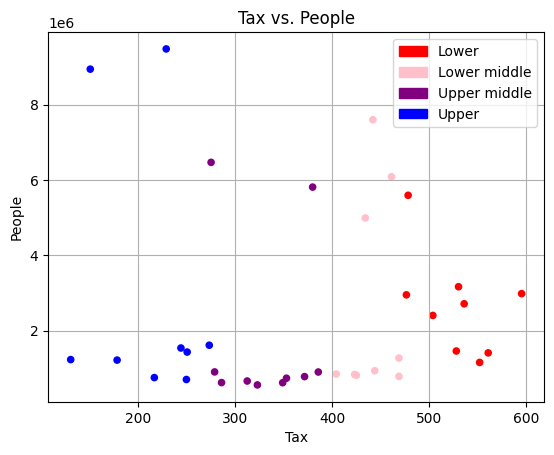

In [ ]:
import sys
import matplotlib # pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

# Convert to Pandas
Pop = Cond_Pop.toPandas()
Inc = Cond_Inc.toPandas()
Sta = Statements.toPandas()
Dat = Cast_Data.toPandas()
Reg = Region.toPandas()

# Visualise data
Ages = Dat['All_ages'].values.tolist()
Tax = Dat['Tot_tax'].values.tolist()

# Create blank list
avg_tax = []

for i in range(len(Ages)):
    avg_tax.append(Ages[i]/Tax[i])

'''
# Create line of best fit
z = np.polyfit(x=Dat.loc[:,'All_ages'],y=Dat.loc[:,'Tot_tax'],deg=1)
p = np.poly1d(z)
Dat['Trendline'] = p(Dat.loc[:,'All_ages'])
'''
cat_var = []

# Create category
for i in range(len(avg_tax)):
    if avg_tax[i] > 469:
        cat_var.append('Lower')
    elif avg_tax[i] > 386 and avg_tax[i] < 469:
        cat_var.append('Lower middle')
    elif avg_tax[i] > 275 and avg_tax[i] < 386:
        cat_var.append('Upper middle')
    else:
        cat_var.append('Upper')

# Add cat_var to dataframe
Dat['Class'] = cat_var
Dat['Avg_tax'] = avg_tax


# Create the groups seen in graph
colours = {'Lower': 'red', 'Lower middle': 'pink', 'Upper middle': 'purple', 'Upper': 'blue'}
colour_list = [colours[group] for group in cat_var]

# Create scatter graph
legend_handles = [mpatch.Patch(color=colours['Lower'],label='Lower'),
                  mpatch.Patch(color=colours['Lower middle'],label='Lower middle'),
                  mpatch.Patch(color=colours['Upper middle'],label='Upper middle'),
                  mpatch.Patch(color=colours['Upper'],label='Upper')]

gro_ax = Dat.plot.scatter('Avg_tax','All_ages',c=colour_list,grid=True)
gro_ax.set_title('Tax vs. People')
gro_ax.set_xlabel('Tax')
gro_ax.set_ylabel('People')
gro_ax.legend(handles=legend_handles)

In [ ]:
# Get region details into list
Codes = Pop['Code'].values.tolist()
Type = Pop['Geography'].values.tolist()

# Create blank 2d list
District = [[]]
c = ''

# Connect each district to its relative region
for i in range(0,len(Codes)):
    if Type[i] == 'Region':
        c = Codes[i]
    if Type[i] == 'Country':
        
    District.append([c, Codes[i]])

print(District)

reg = 0
num = 0

reg_tax = []

# Calculate the regions average tax
for i in range(0, len(District)):
    current = District[i][0]
    if current == District[i][0]:
        reg += avg_tax[i]
        num += 1
    else:
        avg = reg // num
        reg_tax.append(avg)
        reg = 0
        num = 0




[[], ['', 'K04000001'], ['', 'E92000001'], ['E12000001', 'E12000001'], ['E12000001', 'E06000047'], ['E12000001', 'E06000005'], ['E12000001', 'E06000001'], ['E12000001', 'E06000002'], ['E12000001', 'E06000057'], ['E12000001', 'E06000003'], ['E12000001', 'E06000004'], ['E12000001', 'E11000007'], ['E12000001', 'E08000037'], ['E12000001', 'E08000021'], ['E12000001', 'E08000022'], ['E12000001', 'E08000023'], ['E12000001', 'E08000024'], ['E12000002', 'E12000002'], ['E12000002', 'E06000008'], ['E12000002', 'E06000009'], ['E12000002', 'E06000049'], ['E12000002', 'E06000050'], ['E12000002', 'E06000063'], ['E12000002', 'E06000006'], ['E12000002', 'E06000007'], ['E12000002', 'E06000064'], ['E12000002', 'E11000001'], ['E12000002', 'E08000001'], ['E12000002', 'E08000002'], ['E12000002', 'E08000003'], ['E12000002', 'E08000004'], ['E12000002', 'E08000005'], ['E12000002', 'E08000006'], ['E12000002', 'E08000007'], ['E12000002', 'E08000008'], ['E12000002', 'E08000009'], ['E12000002', 'E08000010'], ['E12

IndexError: list index out of range

In [9]:
# Imports
#from sklearn.ensemble import RandomForestClassifier # pip3 install -U scikit-learn scipy matplotlib
from pyspark.ml.classification import RandomForestClassifier # pip install setuptools
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#Cast_Data.printSchema()

# Split data
train_data, test_data = Cast_Data.randomSplit([0.8, 0.2])

# Create classifier
rf = RandomForestClassifier()

# Create target data 
#Cast_Data.summary().show()

Cast_Data.show()

# Create model
#model = rf.fit(train_data)


+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
|All_ages|Num_ind| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|     Code|                Area|
+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
| 2711380|    929|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|E12000001|          North East|
| 1153212|    396|30500| 25000|          197|      3800|          29|        508|   31700|     25200|        508|    4120|      2290|   2090|  2|E11000007|         Tyne & Wear|
| 7600126|   2690|32000| 25000|         1410|      5930|          43|       3490|   34000|     25700|       3490|  